# Paso 0: Conexión con GoogleCloud y carga de tablas

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [2]:
# Libreria para conectarse a BigQuery desde Python
from google.cloud import bigquery

# id del proyecto en Google Cloud
project_id = 'driven-atrium-445021-m2'

# Creación del cliente BigQuery
bq_client = bigquery.Client(project = project_id)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Paso 1: Carga y Unión de las tablas

In [4]:
trips_query_job = bq_client.query('''SELECT pickup_year,
                                      pickup_month,
                                      pickup_day_of_month,
                                      pickup_day_of_week,
                                      pickup_hour_of_day,
                                      pickup_location_id,
                                      COUNT(trip_id) AS total_trips,
                                FROM `driven-atrium-445021-m2.project_data.trips`
                                GROUP BY
                                      pickup_year ,
                                      pickup_month,
                                      pickup_day_of_month ,
                                      pickup_day_of_week,
                                      pickup_hour_of_day,
                                      pickup_location_id
                                ORDER BY
                                      pickup_year,
                                      pickup_month,
                                      pickup_day_of_month,
                                      pickup_hour_of_day,
                                      pickup_location_id''')

bq_trip_counts = trips_query_job.result().to_dataframe()

# el simbolo ~ es para indicar complemento, aqui lo que se hace es tomar todos los valores de location_id MENOS el 264 y 265
# El mapa solo mostrara los location_id que van del 1 al 263, por eso se eliminan 264 y 265 que corresponden a unknown y "outside of NYC"

bq_trip_counts = bq_trip_counts[~bq_trip_counts['pickup_location_id'].isin([264,265])].copy().reset_index(drop=True)
print(bq_trip_counts.shape)
bq_trip_counts.head(2)

(4043843, 7)


,pickup_year,pickup_month,pickup_day_of_month,pickup_day_of_week,pickup_hour_of_day,pickup_location_id,total_trips
0,2023,1,1,6,0,2,1
1,2023,1,1,6,0,3,59


In [5]:
bq_trip_counts.tail(2)

,pickup_year,pickup_month,pickup_day_of_month,pickup_day_of_week,pickup_hour_of_day,pickup_location_id,total_trips
4043841,2024,10,31,3,23,262,132
4043842,2024,10,31,3,23,263,348


## La data de los viajes va desde el 01/01/2023 hasta el 31/10/2024, lo cual se tomara en cuenta para el clima también.

In [6]:
weather_query_job = bq_client.query('''SELECT *
                                        FROM `driven-atrium-445021-m2.project_data.weather`''')
clima = weather_query_job.result().to_dataframe()
print(clima.shape)
clima.head(2)

(80400, 16)


,location_id,year,month,day_of_month,hour_of_day,day_of_week,temperature,relative_humidity,dew_point,apparent_temperature,weather_code,pressure_msl,cloud_cover,wind_speed,wind_direction,wind_gusts
0,3,2023,5,1,15,0,14.6,43.0,2.3,9.2,0.0,994.3,18.0,25.2,217.0,54.4
1,1,2024,7,1,18,0,25.1,46.0,12.7,23.5,0.0,1017.4,6.0,17.0,354.0,38.5


## Se observa que la data de clima tiene 80.400 filas, que corresponden a todas las condiciones del clima, en todas las horas (24 h), desde el 01/01/2023 hasta el 31/10/2024 (670 días) en las 5 ubicaciones consultadas (5 boroughs).

In [7]:
clima.rename(columns={'location_id':'borough_id'}, inplace=True)
clima.head(2)

,borough_id,year,month,day_of_month,hour_of_day,day_of_week,temperature,relative_humidity,dew_point,apparent_temperature,weather_code,pressure_msl,cloud_cover,wind_speed,wind_direction,wind_gusts
0,3,2023,5,1,15,0,14.6,43.0,2.3,9.2,0.0,994.3,18.0,25.2,217.0,54.4
1,1,2024,7,1,18,0,25.1,46.0,12.7,23.5,0.0,1017.4,6.0,17.0,354.0,38.5


## Se hace el cambio porque este location_id no representa lo mismo que la columna con el mismo nombre en la tabla de viajes.<br><br>Tambien este cambio de nombre facilitará el merge que se hará mas adelante.

In [8]:
boroughs_query_job = bq_client.query('''SELECT *
                                        FROM `driven-atrium-445021-m2.project_data.coordinates`''')
boroughs = boroughs_query_job.result().to_dataframe()

# el locationID 1 es un borough unico, y el mas cercano es Manhattan, por lo que por simplicidad se le asignó ese borough.

id_boroughs = {'Queens':1,'Brooklyn':2,'Manhattan':3,'Bronx':4,'Staten Island':5, 'EWR':3}
boroughs['borough_id'] = boroughs['borough'].map(id_boroughs)\
                                            .convert_dtypes(convert_integer=True)

# Columna que no se usarán ni necesitarán
boroughs.drop(columns=['geom','poligon'],inplace=True)

print(boroughs.shape)
boroughs.head(2)

(263, 4)


,location_id,zone,borough,borough_id
0,1,Newark Airport,EWR,3
1,3,Allerton/Pelham Gardens,Bronx,4


## Esta tabla tiene 263 filas, correspondiente a las 263 zonas que hay en Nueva York de acuardo al TLC NYC (ente regulador de taxis).

In [9]:
# Merge para crear tabla base que contiene todas las condiciones climaticas en todas las 263 zonas a TODAS las horas.
# Esto permitira hacer el JOIN con viajes y capturar los valores nulos que representan valores de cero viajes.
clima_borough_merge = boroughs.merge(clima,how='left', on='borough_id')

print(clima_borough_merge.shape)
clima_borough_merge.head(2)

(4229040, 19)


,location_id,zone,borough,borough_id,year,month,day_of_month,hour_of_day,day_of_week,temperature,relative_humidity,dew_point,apparent_temperature,weather_code,pressure_msl,cloud_cover,wind_speed,wind_direction,wind_gusts
0,1,Newark Airport,EWR,3,2023,5,1,15,0,14.6,43.0,2.3,9.2,0.0,994.3,18.0,25.2,217.0,54.4
1,1,Newark Airport,EWR,3,2023,5,1,4,0,8.5,83.0,5.8,4.2,0.0,988.2,0.0,21.6,266.0,47.2


## El dataset contiene 4.229.040 registros, correspondientes a todas las horas (80400) por cada zona de Nueva York (263).

In [10]:
# Cambiando los nombres de las columnas en la tabla de viajes para hacer el merge con clima_boroughs.

bq_trip_counts.rename(columns={'pickup_year':'year',
                               'pickup_month':'month',
                               'pickup_day_of_month':'day_of_month',
                               'pickup_hour_of_day':'hour_of_day',
                               'pickup_location_id':'location_id',
                               'pickup_day_of_week':'day_of_week'}, inplace=True)

bq_trip_counts.head(3)

,year,month,day_of_month,day_of_week,hour_of_day,location_id,total_trips
0,2023,1,1,6,0,2,1
1,2023,1,1,6,0,3,59
2,2023,1,1,6,0,4,190


In [11]:
ML_merge = clima_borough_merge.merge(bq_trip_counts,
                                     how='left',
                                     on=['location_id',
                                         'year',
                                         'month',
                                         'day_of_month',
                                         'day_of_week',
                                         'hour_of_day'])

print(ML_merge.shape)
ML_merge.head(2)

(4229040, 20)


,location_id,zone,borough,borough_id,year,month,day_of_month,hour_of_day,day_of_week,temperature,relative_humidity,dew_point,apparent_temperature,weather_code,pressure_msl,cloud_cover,wind_speed,wind_direction,wind_gusts,total_trips
0,1,Newark Airport,EWR,3,2023,5,1,15,0,14.6,43.0,2.3,9.2,0.0,994.3,18.0,25.2,217.0,54.4,<NA>
1,1,Newark Airport,EWR,3,2023,5,1,4,0,8.5,83.0,5.8,4.2,0.0,988.2,0.0,21.6,266.0,47.2,<NA>


In [12]:
ML_merge.isna().sum()

,0
location_id,0
zone,0
borough,0
borough_id,0
year,0
month,0
day_of_month,0
hour_of_day,0
day_of_week,0
temperature,0


## Aquí podemos observar que luego de este merge entre las tablas hay 185197 valores nulos. <br><br> Al contar el numero de viajes por location_id, aquellas zonas que tienen 0 viajes a determinadas horas no se registran en las tablas.<br><br> El modo como se diseñaron las tablas en este notebook permite registrar esos valores que son necesarios para un correcto entrenamiento del modelo ML. A continuación se procederá a sustituir estos valores nulos.

In [13]:
ML_merge.fillna(0,inplace=True)
ML_merge.isna().sum()

,0
location_id,0
zone,0
borough,0
borough_id,0
year,0
month,0
day_of_month,0
hour_of_day,0
day_of_week,0
temperature,0


# Paso 2: Graficos y Correlaciones

## Terminada la carga y unión de tablas, y la correspondiente imputación de valores nulos explicada anteriormente, se procede a mostrar los graficos pertinentes.<br><br> Primero los viajes

In [14]:
# Conteo de viajes SIN SEPARAR por location_id, para repetir lo hecho en EDAs anteriores pero con TODA la data.

trip_counts = bq_trip_counts.groupby(['year', 'month', 'day_of_month', 'day_of_week', 'hour_of_day'])\
                                .agg(Count=('hour_of_day','count'))\
                                .reset_index()

trip_counts.head(3)

,year,month,day_of_month,day_of_week,hour_of_day,Count
0,2023,1,1,6,0,255
1,2023,1,1,6,1,253
2,2023,1,1,6,2,255


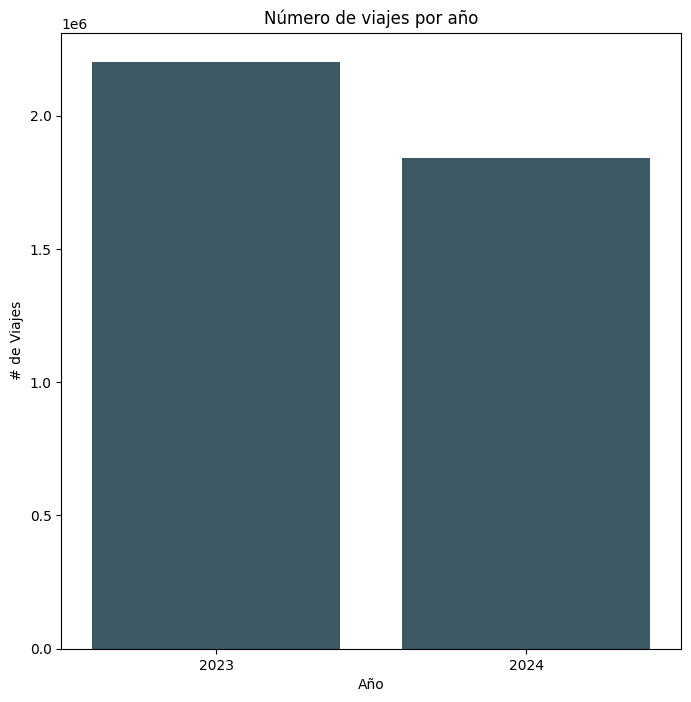

In [15]:
plt.figure(figsize=(8,8))
sns.countplot(data=bq_trip_counts,x='year',order=[2023,2024],color='#365B6D')
plt.title('Número de viajes por año')
plt.xlabel('Año')
plt.ylabel('# de Viajes')
plt.show()

## La discrepancia observada acá es debido a que se tiene la data de todo el año 2023, mientras que para el 2024 solo se tiene hasta octubre (primeros 10 meses).

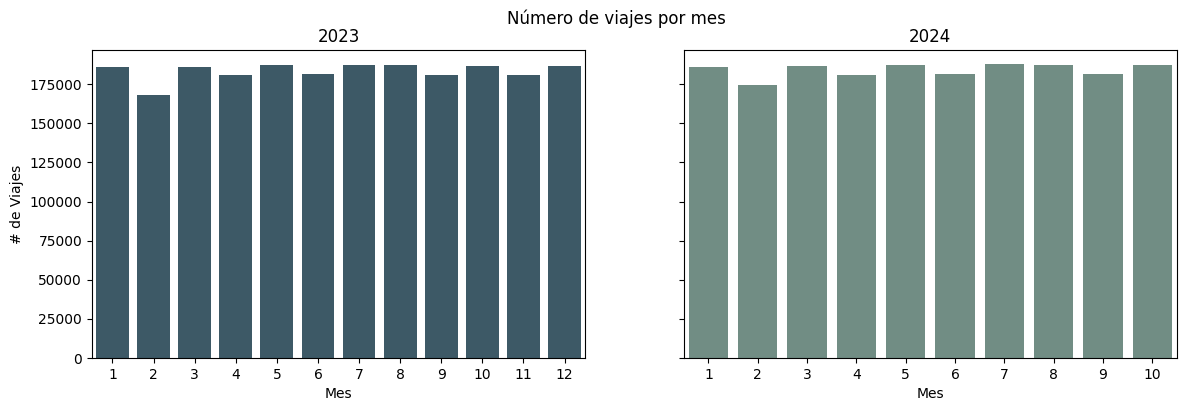

In [16]:
figure, axes = plt.subplots(1, 2, figsize=(14,4),sharey=True)
figure.suptitle('Número de viajes por mes')

plt.setp([axes[0].get_xticklabels(),axes[1].get_xticklabels()], rotation=0)

axes[0].set_title('2023')
axes[0].set_xlabel('Mes')

axes[1].set_title('2024')
axes[1].set_xlabel('Mes')

axes[0].set_ylabel('# de Viajes')


sns.countplot(ax=axes[0],data=bq_trip_counts[bq_trip_counts['year']==2023],x='month', color='#365B6D')
sns.countplot(ax=axes[1],data=bq_trip_counts[bq_trip_counts['year']==2024],x='month', color='#6C9286')
plt.show()

## Se observa que todos los valores se encuentran alrededor de 175000 viajes por mes.<br><br>Las diferencias entre meses se deben al numero de días que tiene cada mes. Es por ellos que el mes mas bajo es febrero, y los meses que tienen 31 días están por encima de los meses con 30 días.



In [17]:
promedio_diario=trip_counts.drop(columns=['month','day_of_week']).groupby(by=['day_of_month'],as_index=False).mean()
promedio_diario.head(2)

,day_of_month,year,hour_of_day,Count
0,1,2023.454545,11.5,251.551136
1,2,2023.454545,11.5,251.545455


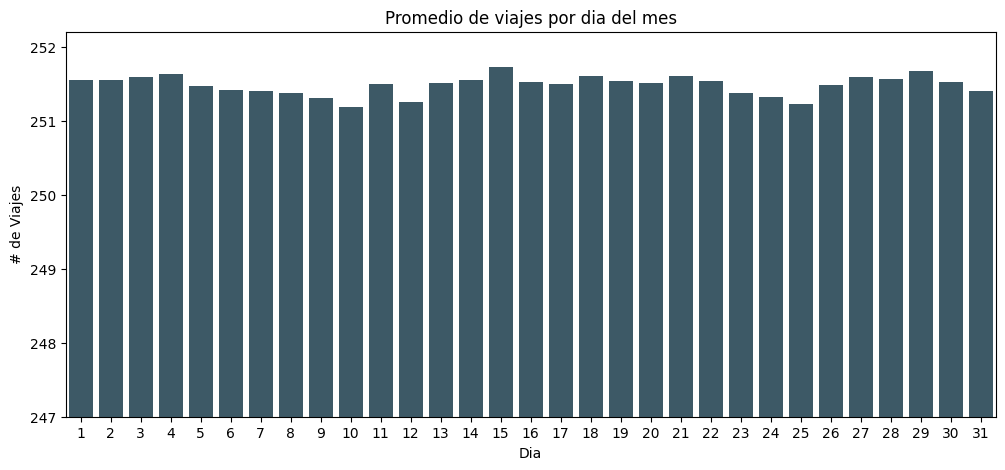

In [18]:
plt.figure(figsize=(12,5))
sns.barplot(data=promedio_diario, x='day_of_month', y='Count',color='#365B6D')
plt.title('Promedio de viajes por dia del mes')
plt.xlabel('Dia')
plt.ylabel('# de Viajes')
plt.ylim(247,252.2)
plt.yticks(np.arange(247,253, step=1))
plt.show()

## Aquí se observa que el promedio de viajes por dia oscila entre 251 y 252 sin observarse alguna tendencia clara que indique alguna preferencia por un dia del mes en particular.

In [19]:
promedio_dia_semana=trip_counts.drop(columns=['month']).groupby(by=['day_of_week'],as_index=False).mean()
promedio_dia_semana.head(2)

,day_of_week,year,day_of_month,hour_of_day,Count
0,0,2023.458333,15.59375,11.5,250.988281
1,1,2023.458333,15.958333,11.5,250.626736


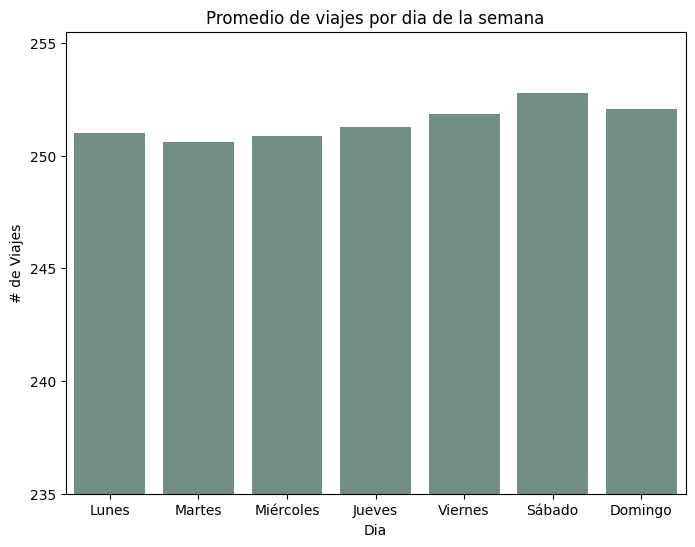

In [20]:
plt.figure(figsize=(8,6))
sns.barplot(data=promedio_dia_semana, x='day_of_week', y='Count', color='#6C9286')
plt.title('Promedio de viajes por dia de la semana')
plt.xlabel('Dia')
plt.ylabel('# de Viajes')
plt.ylim(235,255.5)
plt.yticks(np.arange(235,256, step=5))
plt.xticks([0,1,2,3,4,5,6],['Lunes','Martes','Miércoles','Jueves','Viernes','Sábado','Domingo'])
plt.show()

## Al evaluar por día de la semana, se ve que el promedio oscila entre 250 y 253 viajes por día, donde hay una mayor demanda hacia los fines de semana, en particular los sábados.

In [21]:
promedio_hora=trip_counts.drop(columns=['month']).groupby(by=['day_of_week','hour_of_day'],as_index=False).mean()

promedio_hora.head(2)

,day_of_week,hour_of_day,year,day_of_month,Count
0,0,0,2023.458333,15.59375,250.65625
1,0,1,2023.458333,15.59375,246.927083


In [22]:
weekday_name = {0:'Lunes',1:'Martes',2:'Miércoles',3:'Jueves',4:'Viernes',5:'Sábado',6:'Domingo'}
promedio_hora['weekday_name'] = promedio_hora['day_of_week'].map(weekday_name)
promedio_hora.head(3)

,day_of_week,hour_of_day,year,day_of_month,Count,weekday_name
0,0,0,2023.458333,15.59375,250.65625,Lunes
1,0,1,2023.458333,15.59375,246.927083,Lunes
2,0,2,2023.458333,15.59375,243.291667,Lunes


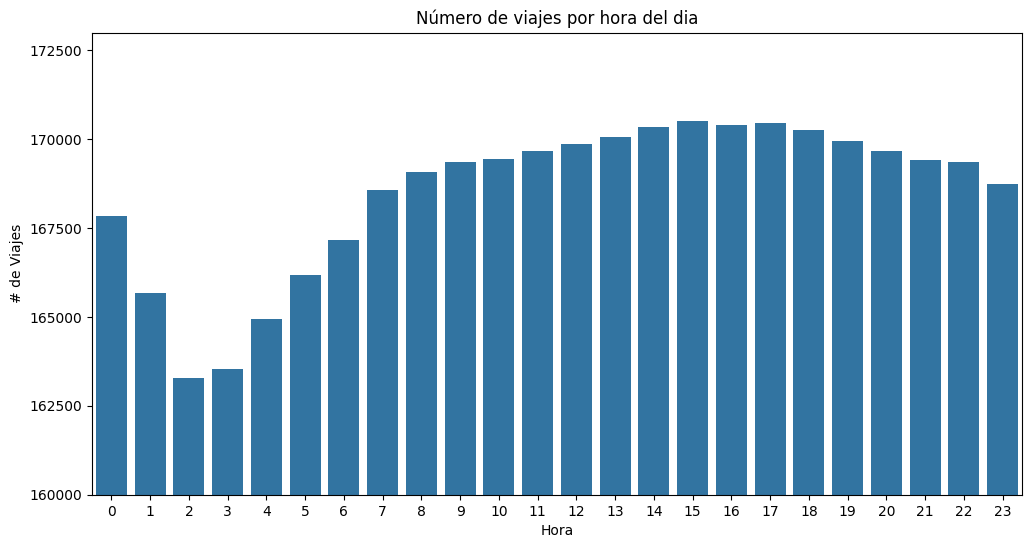

In [23]:
plt.figure(figsize=(12,6))
sns.countplot(data=bq_trip_counts,x='hour_of_day')
plt.title('Número de viajes por hora del dia')
plt.xlabel('Hora')
plt.ylim(160000,173000)
plt.yticks(np.arange(160000,173000, step=2500))
plt.ylabel('# de Viajes')
plt.show()

## Acá se contabiliza el número de viajes de acuerdo a la hora del día, donde se ve la mayor variación desde horas de la madrugada con esta el minimo de demanda, que aumenta rapido durante las primeras horas de la mañana hasta llegar a su máximo a mediados-finales de la tarde, para luego volver a descender hasta su mínimo durante la noche.

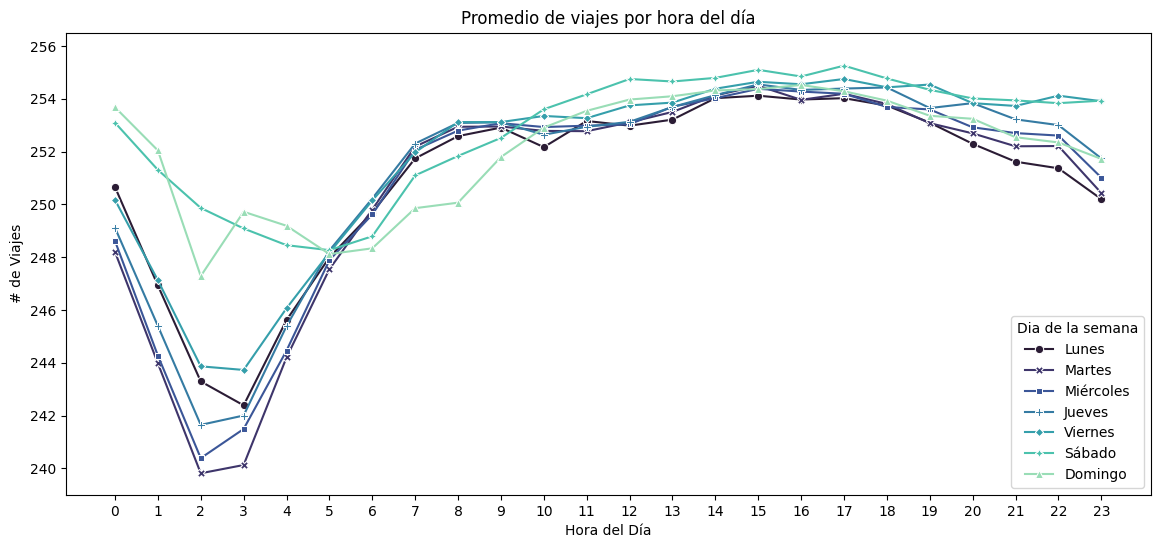

In [24]:
plt.figure(figsize=(14,6))
sns.lineplot(data=promedio_hora,
             x=promedio_hora['hour_of_day'],
             y=promedio_hora['Count'],
             hue=promedio_hora['weekday_name'],
             hue_order=['Lunes','Martes','Miércoles','Jueves','Viernes','Sábado','Domingo'],
             errorbar=None,
             markers=True,
             palette='mako',
             style=promedio_hora['weekday_name'],
             dashes=False)

plt.title('Promedio de viajes por hora del día')
plt.xlabel('Hora del Día')
plt.ylabel('# de Viajes')
plt.legend(title='Dia de la semana')
plt.ylim(239,256.5)
plt.xticks(np.arange(0,24, step=1))
plt.show()

## Acá se grafica el promedio de viajes de acuerdo a la hora del día, separando por el día de la semana, donde se sigue observando la misma tendencia descrita anteriormente (minimo en la madrugada, máximo al final de la tarde), pero podemos notar que el comportamiento durante el día se puede separar en 2 grupos de muestran una curva diferente: los días de la semana (Lun-Vie) vs. los fines de semana (Sáb-Dom).

In [25]:
location_sum = ML_merge.groupby(by=['location_id'],as_index=False).sum()
location_sum.shape

(263, 20)

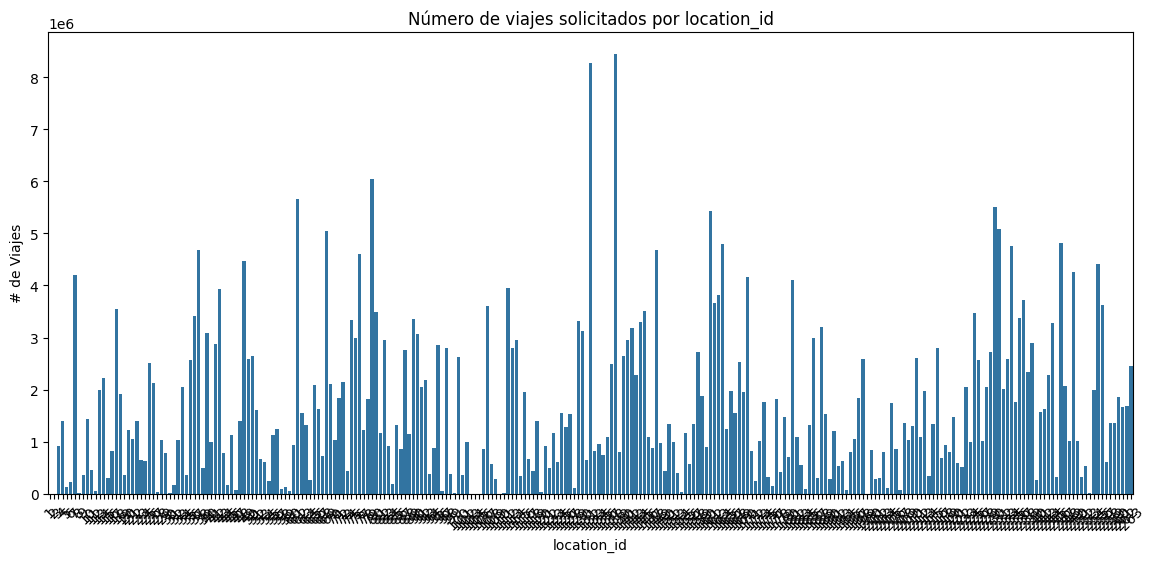

In [26]:
plt.figure(figsize=(14,6))
sns.barplot(data=location_sum,x='location_id',y='total_trips')
plt.title('Número de viajes solicitados por location_id')
plt.xlabel('location_id')
plt.ylabel('# de Viajes')
plt.xticks(rotation=45)
plt.show()

## Acá observamos el conteo de viajes total en el período de tiempo estudiado separado por zonas, donde se observa grandes diferencias entre una zona y otra.<br><br>A continuación se mostrarán graficos con las zonas con mas viajes.

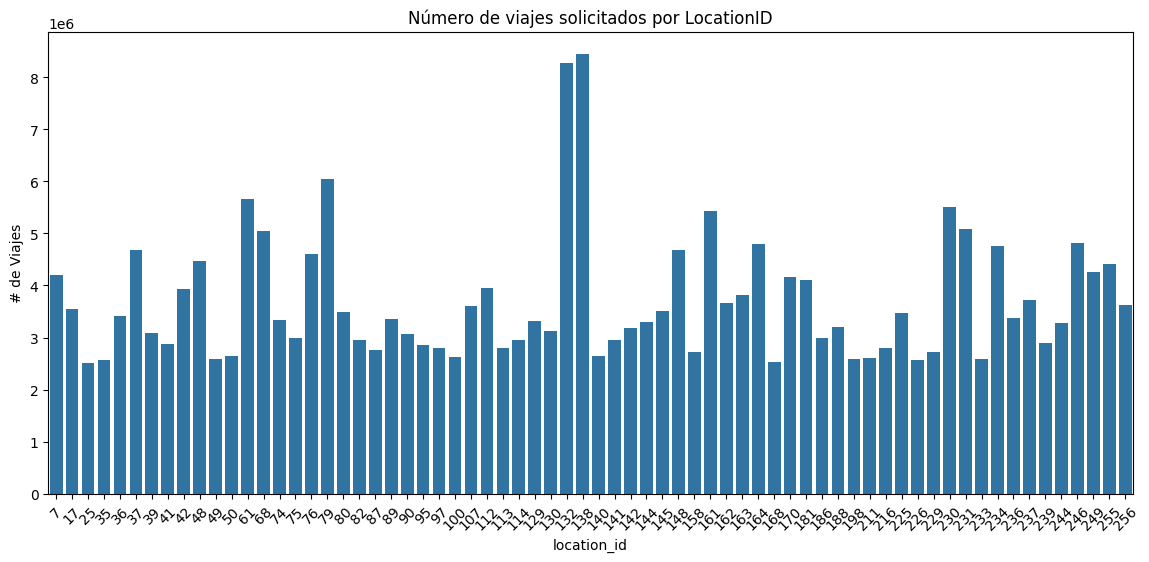

In [27]:
plt.figure(figsize=(14,6))
sns.barplot(data=location_sum[location_sum['total_trips']>2500000],x='location_id',y='total_trips')
plt.title('Número de viajes solicitados por LocationID')
plt.xlabel('location_id')
plt.ylabel('# de Viajes')
plt.xticks(rotation=45)
plt.show()

In [28]:
location_sum[location_sum['total_trips']>2500000].shape

(68, 20)

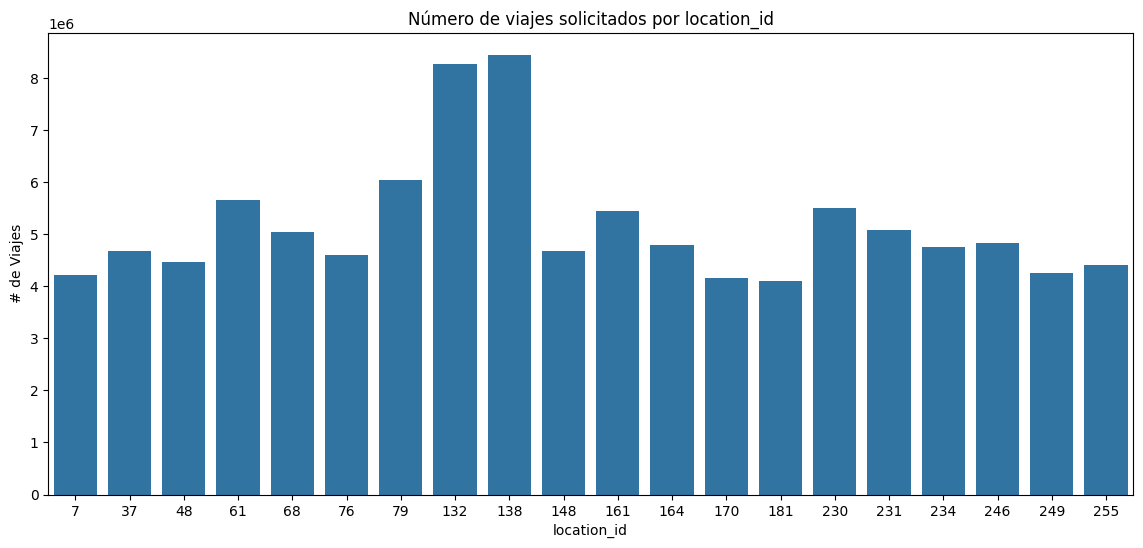

In [29]:
plt.figure(figsize=(14,6))
sns.barplot(data=location_sum[location_sum['total_trips']>4000000],x='location_id',y='total_trips')
plt.title('Número de viajes solicitados por location_id')
plt.xlabel('location_id')
plt.ylabel('# de Viajes')
plt.show()

In [30]:
location_sum[location_sum['total_trips']>4000000].shape

(20, 20)

## En los 2 graficos anteriores se observa que, de todas las 263 zonas, 68 tienen más de 2.5M de viajes y solo 20 acumulan más de 4M de viajes.

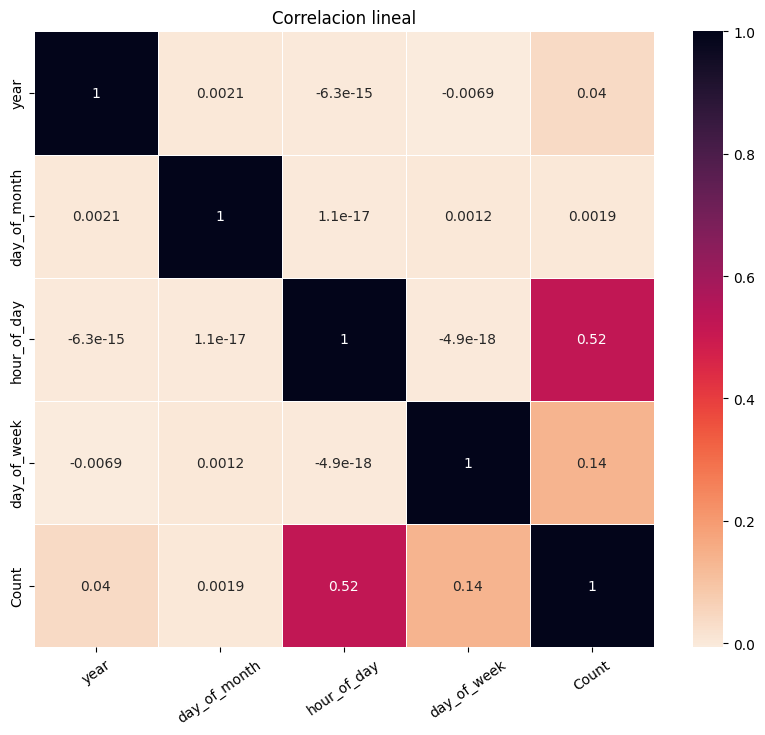

In [31]:
# Usando trip_counts que NO diferencia entre los locationID

time_corr = trip_counts[['year', 'day_of_month', 'hour_of_day','day_of_week', 'Count']].corr(method='pearson')

plt.figure(figsize=(10,8))
sns.heatmap(time_corr, annot=True, linewidth=.5,cmap='rocket_r')
plt.title('Correlacion lineal')
plt.xticks(rotation=35)
plt.show()

## Acá se muestra en un mapa de calor lo que los graficos también mostrarion, que es que los atributos de hora del día y día de la semana son los que tienen mayor correlación con el numero de viajes.

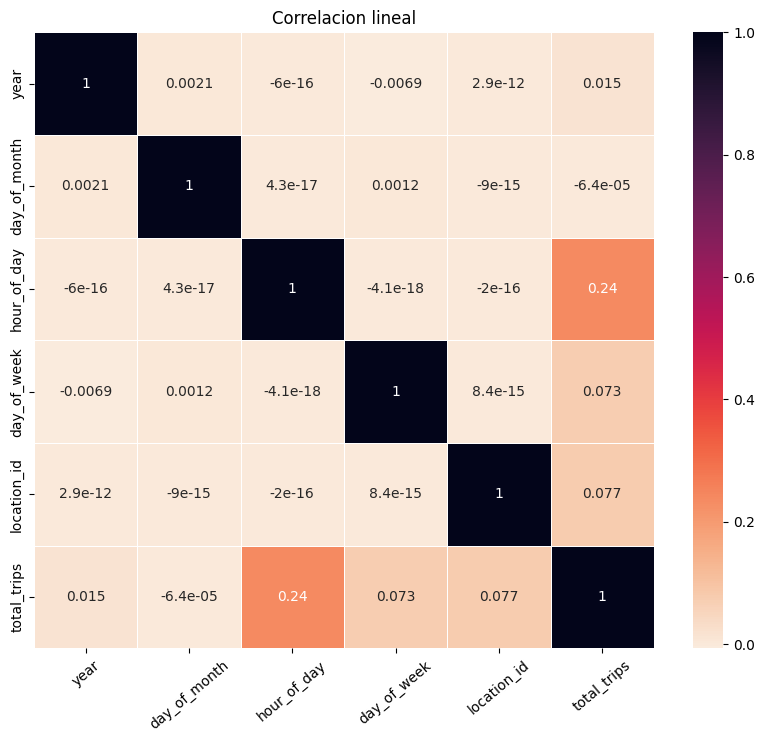

In [32]:
# Usando ML_merge que los separa por locationID y ademas considera los valores 0

time_location_corr = ML_merge[['year', 'day_of_month', 'hour_of_day', 'day_of_week','location_id', 'total_trips']].corr(method='pearson')

plt.figure(figsize=(10,8))
sns.heatmap(time_location_corr, annot=True, linewidth=.5,cmap='rocket_r')
plt.title('Correlacion lineal')
plt.xticks(rotation=40)
plt.show()

## Aquí se repite el análisis anterior, pero considerando las zonas, las cuales también influyen en el conteo de viajes.

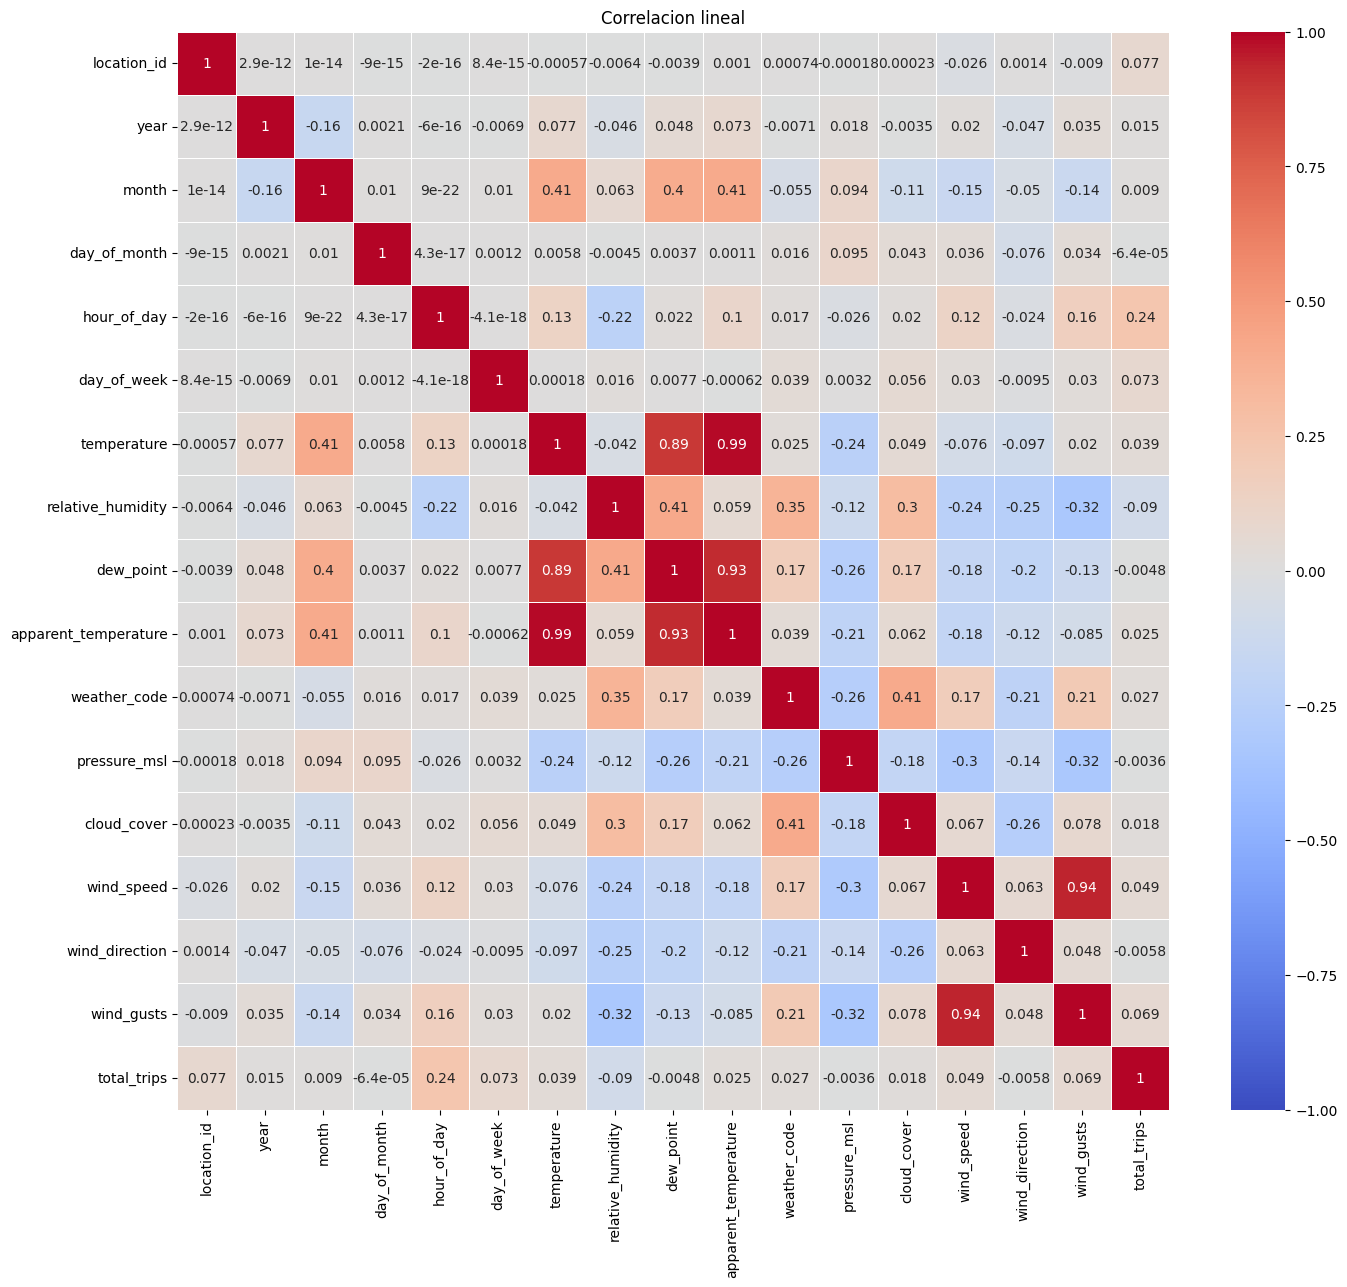

In [33]:
# Usando ML_merge que los separa por locationID y ademas considera los valores 0

weather_location_corr = ML_merge[['location_id', 'year', 'month',
       'day_of_month', 'hour_of_day', 'day_of_week', 'temperature',
       'relative_humidity', 'dew_point', 'apparent_temperature',
       'weather_code', 'pressure_msl', 'cloud_cover', 'wind_speed',
       'wind_direction', 'wind_gusts', 'total_trips']].corr(method='pearson')

plt.figure(figsize=(16,14))
sns.heatmap(weather_location_corr, annot=True, linewidth=.5, cmap='coolwarm', vmin=-1)
plt.title('Correlacion lineal')
plt.xticks(rotation=90)
plt.show()

# Paso 3: Sugerencias finales

In [34]:
ML_merge.columns

Index(['location_id', 'zone', 'borough', 'borough_id', 'year', 'month',
       'day_of_month', 'hour_of_day', 'day_of_week', 'temperature',
       'relative_humidity', 'dew_point', 'apparent_temperature',
       'weather_code', 'pressure_msl', 'cloud_cover', 'wind_speed',
       'wind_direction', 'wind_gusts', 'total_trips'],
      dtype='object')

## Acá podemos ver las correlaciones entre todos los atributos que se evaluarán para el producto ML, incluyendo su relación con el conteo de viajes.<br><br>Lo primero que observamos son las siguientes correlaciones:<br><br>Fuerte correlacion entre 'temperature', 'dew_point' y 'apparent_temperature', junto con una correlación debil con 'month', donde se recomienda quedarse con 'apparent_temperature'.<br><br>Una moderada correlacion entre 'relative_humidity','weather_code', 'cloud_cover'. Se recomienda quedarse con 'weather_code'.<br><br>Otra moderada correlacion entre 'pressure_msl', 'wind_speed' y 'wind_gusts'. Aquí se consideraría 'wind_speed'.<br><br>Tambíen se recomienda descartar año, donde sólo hay 2 valores, y dia del mes, que en los graficos mostró tener poca incidencia en el conteo de viajes, y 'wind_direction' que no muestra correlación importante con el numero de viajes.

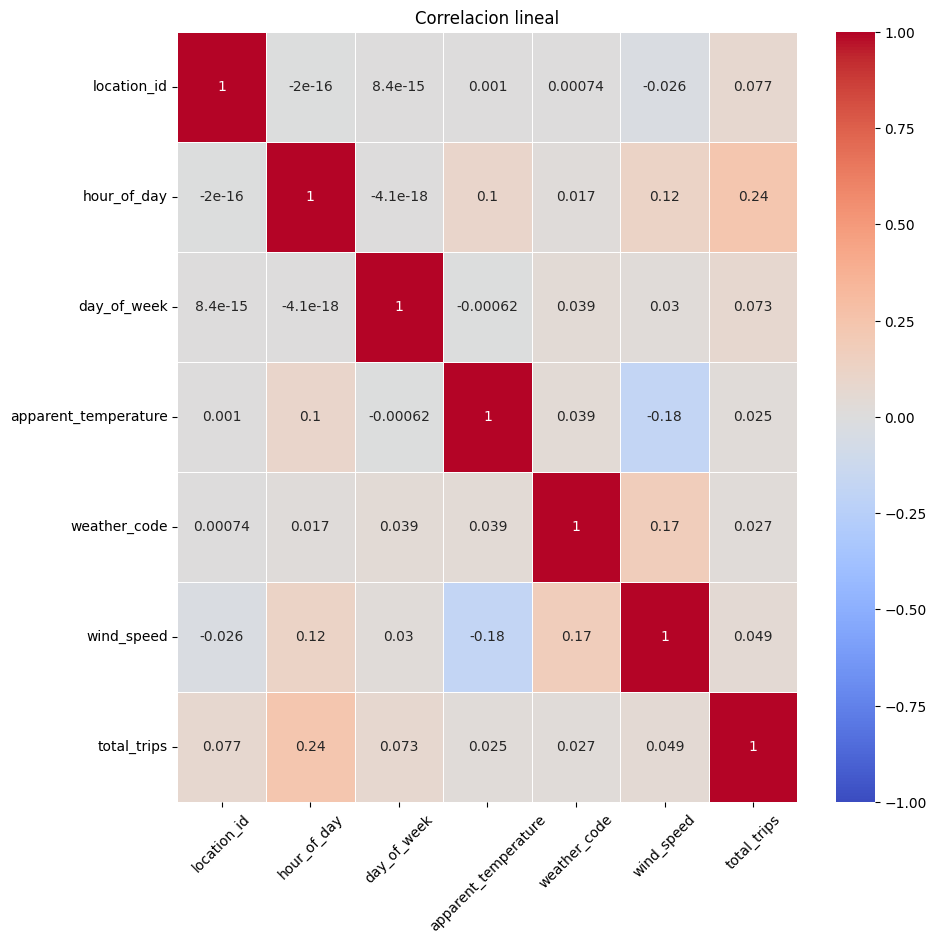

In [35]:
weather_location_corr = ML_merge[['location_id', 'hour_of_day', 'day_of_week',
                                  'apparent_temperature', 'weather_code', 'wind_speed',
                                  'total_trips']].corr(method='pearson')

plt.figure(figsize=(10,10))
sns.heatmap(weather_location_corr, annot=True, linewidth=.5, cmap='coolwarm', vmin=-1)
plt.title('Correlacion lineal')
plt.xticks(rotation=45)
plt.show()

## Luego de remover las columnas que estaban correlacionadas y aquellas que por análisis debían ser descartadas, obtenemos el siguiente mapa de calor de correlaciones, que se sugiere utilizar como punto de partida para el entrenamiento y optimización del producto ML.

In [36]:
# Lista de columnas para el inicio de entrenamiento del modelo ML

# ['location_id', 'hour_of_day', 'day_of_week', 'apparent_temperature', 'weather_code', 'wind_speed', 'total_trips']